In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

In [2]:
target = 'gaussian'

In [3]:
results = []
for trial in os.listdir('denoise/'):
    if trial.split('_')[0] == target and '07-1' in trial and 'householder' not in trial:
        results.append(trial)
        
results.sort()
results

['gaussian_0#0.05_None_None_random_0.0185_07-10-2021 00:10',
 'gaussian_0#0.05_None_None_random_0.01_07-11-2021 23:08']

In [4]:
def load_trained(path):
    path = os.path.join('denoise', path)
    residual_curve = np.load(os.path.join(path, 'residual_curve.npy'))
    psnr_curve = np.load(os.path.join(path, 'psnr_curve.npy'))
    try: 
        gamma_curve = np.load(os.path.join(path, 'gamma_curve.npy'))
    except:
        gamma_curve = None
        
    noise = np.load(os.path.join(path, 'noise.npy'))
    noisy = np.load(os.path.join(path, 'noisy.npy'))
    original = np.load(os.path.join(path, 'original.npy'))
    
    base_noisy = np.load(os.path.join(path, 'base_noisy.npy'))
    base_original = np.load(os.path.join(path, 'base_original.npy'))
    
    recovered_cps = [str(x) for x in Path(path).glob("**/recovered_*.npy")]
    recovered_cps.sort()
    base_cps = [str(x) for x in Path(path).glob("**/base_*.npy") if 'noisy' not in str(x) and 'original' not in str(x)]
    base_cps.sort()
    
    return noise, noisy, original, base_noisy, base_original, recovered_cps, base_cps, residual_curve, psnr_curve, gamma_curve

def l2norm(batch_data):
    return np.sqrt((batch_data ** 2).reshape(len(batch_data), -1).sum(1))

In [8]:
original_showed = False

for trial in results:
    gamma = trial.split('_')[5]
    noise_info = trial.split('_')[1]
    noise_loc, noise_scale = noise_info.split('#')
    noise, noisy, original, base_noisy, base_original, recovered_cps, base_cps, residual_curve, psnr_curve, gamma_curve = load_trained(trial)

In [41]:
import torch 
from torchvision import transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


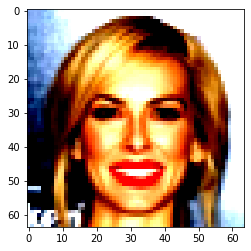

In [47]:
t = torch.nn.Sequential(
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)

scripted_transforms = torch.jit.script(t)

t_img = scripted_transforms(torch.from_numpy(original[0]).permute(2, 0, 1))
plt.imshow(t_img.permute(1, 2, 0))

tensor(0.0020)

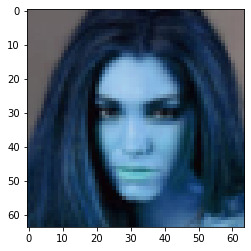

In [108]:
# t = torch.nn.Sequential(
# #     transforms.ColorJitter(brightness=0, contrast=(1 / 1.5, 1 / 1.5), saturation=0, hue=0)
# #     transforms.ColorJitter(brightness=0, contrast=(1 / .8, 1 / .8), saturation=0, hue=0)
#         transforms.ColorJitter(hue=(.5, .5))
# )

# t = torch.nn.Sequential(
# #     transforms.ColorJitter(brightness=0, contrast=(1 / 1.5, 1 / 1.5), saturation=0, hue=0)
# #     transforms.ColorJitter(brightness=0, contrast=(1 / .8, 1 / .8), saturation=0, hue=0)
#         transforms.ColorJitter(hue=(.5, .5))
# )
    
scripted_transforms = torch.jit.script(transforms.ColorJitter(hue=(.5, .5)))

t_img = scripted_transforms(torch.from_numpy(original[1]).permute(2, 0, 1))
plt.imshow(t_img.permute(1, 2, 0))

(t_img - original[1].transpose(2, 0, 1)).mean()

tensor(0.0020)

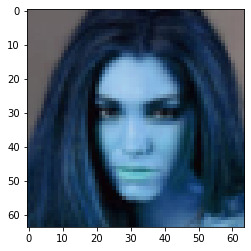

In [102]:
t = torch.nn.Sequential(
#     transforms.ColorJitter(brightness=0, contrast=(1 / 1.5, 1 / 1.5), saturation=0, hue=0)
#     transforms.ColorJitter(brightness=0, contrast=(1 / .8, 1 / .8), saturation=0, hue=0)
        transforms.ColorJitter(hue=(0., 0.))
)

scripted_transforms = torch.jit.script(t)

i_img = scripted_transforms(t_img)
plt.imshow(i_img.permute(1, 2, 0))

(i_img - original[1].transpose(2, 0, 1)).mean()

In [103]:
def invertible_color_jitter(deviation, augmentations):
    aug = {'brightness': (0., 0.),
           'contrast': (0., 0.),
           'saturation': (0., 0.),
           'hue': (0., 0.)}
    invert_aug = {'brightness': (0., 0.),
                  'contrast': (0., 0.),
                  'saturation': (0., 0.),
                  'hue': (0., 0.)}

    for augment in augmentations:
        if augment == 'hue':
            hue_deviation = np.clip(deviation, -.5, .5)
            aug[augment] = (hue_deviation, hue_deviation)
            invert_aug[augment] = (-hue_deviation, -hue_deviation)
        else:
            classical_deviation = 1 + deviation
            aug[augment] = (classical_deviation, classical_deviation)
            invert_aug[augment] = (1 / classical_deviation, 1 / classical_deviation)

    print(aug, invert_aug)

    augmentation = torch.nn.Sequential(
        transforms.ColorJitter(brightness=aug['brightness'],
                               contrast=aug['contrast'],
                               saturation=aug['saturation'],
                               hue=aug['hue']),
        )

    invert_augmentation = torch.nn.Sequential(
        transforms.ColorJitter(brightness=invert_aug['brightness'],
                               contrast=invert_aug['contrast'],
                               saturation=invert_aug['saturation'],
                               hue=invert_aug['hue']),
        )

    return torch.jit.script(augmentation), torch.jit.script(invert_augmentation)


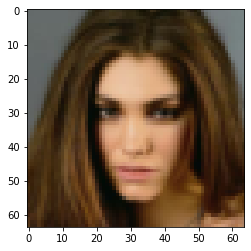

In [107]:
deivation = .2
augmentations = ['brightness']
invertible_color_jitter(deivation, augmentations)

{'brightness': (1.2, 1.2), 'contrast': (0.0, 0.0), 'saturation': (0.0, 0.0), 'hue': (0.0, 0.0)} {'brightness': (0.8333333333333334, 0.8333333333333334), 'contrast': (0.0, 0.0), 'saturation': (0.0, 0.0), 'hue': (0.0, 0.0)}


(RecursiveScriptModule(
   original_name=Sequential
   (0): RecursiveScriptModule(original_name=ColorJitter)
 ),
 RecursiveScriptModule(
   original_name=Sequential
   (0): RecursiveScriptModule(original_name=ColorJitter)
 ))